In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import pickle
import phate
import scipy
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA

In [2]:
%matplotlib ipympl

## Functions

In [3]:
def sub_vectors_between(set_vectors, a, b):
    # this function selects a set of vectors whose entries are between a and b
    
    filtered_vector = [[x for x in v if a < x < b] for v in set_vectors ]
    return filtered_vector        

def list_vector_indices_upto(list_indices, list_of_nums):
    result_list = [[list_indices[i][j] for j in range(list_of_nums[i] + 1)] for i in range(len(list_indices))]
    return result_list

def list_vector_of_index(set_vectors, list_indices):
    
    list_result_vectors = [np.array([set_vectors[i] for i in list_indices[j]]) for j in range(len(list_indices))]
    return list_result_vectors 



def find_basis(point_cloud, x, epsilon_PCA = 0.1, dim = 2, tau_ratio = 1.5):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    epsilon_sqrt = np.sqrt(epsilon_PCA)
    tau = tau_ratio * epsilon_sqrt

    # Number of neighbors to find, we take 5% of the total population
    k = int(0.05 * point_cloud.shape[0])
    
    # Create a NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)

    # Find k nearest neighbors
    dist_i, indx_i = nbrs.kneighbors(x)
    # Find epsilon neighborhood
    dist_epsilon = sub_vectors_between(dist_i, 0, epsilon_sqrt)
    len_dist_epsilon = [len(v) for v in dist_epsilon]
    epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_epsilon))[0]
    # Find tau neighborhood
    dist_tau = sub_vectors_between(dist_i, 0, tau)
    len_dist_tau = [len(v) for v in dist_tau]
    tau_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_tau))[0]
    num = len(tau_neighborhood)
    
    distances, indices = nbrs.kneighbors(tau_neighborhood)
    
    distances_epsilon = sub_vectors_between(distances, 0, epsilon_sqrt) # this is the list of distances in the epsilon
    list_len_dist_epsilon = [len(v) for v in distances_epsilon] #this gives the list of lengths in the distance_epsilon 
    
    tau_epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indices, list_len_dist_epsilon))
    list_X_i = [tau_epsilon_neighborhood[i][1:] - tau_neighborhood[i] for i in range(num)]
    
    
    #list_D_i = [np.diag(np.sqrt(np.exp(- np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for i in range(num)]
    list_D_i = [np.diag(np.sqrt(np.exp( - 5 * np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for 
                i in range(num)]
    list_B_i = [list_X_i[j].T @ list_D_i[j] for j in range(num)]
    O = []
    for q in range(num):
        U, S, VT = np.linalg.svd(list_B_i[q], full_matrices = False)
        O_i = U[:dim, :]
        O.append(O_i)
        
    return epsilon_neighborhood, tau_neighborhood, tau_epsilon_neighborhood, O

def compute_curvature(point_cloud, query_point, epsilon_PCA = 0.1, dim = 2, tau_ratio = 1.5):
    
    ep_neighbor, tau_neighbor, tau_epsilon_neighbor, O = find_basis(point_cloud, query_point, epsilon_PCA = epsilon_PCA,
                                                                    dim = dim, tau_ratio = tau_ratio)
    
    transport_maps = np.zeros((len(tau_neighbor), len(tau_neighbor), dim, dim))
    for i in range(len(tau_neighbor)):
        for j in range(len(tau_neighbor)):
            U, S, VT = np.linalg.svd(O[i] @ O[j].T, full_matrices = False)
            O_ij = U @ VT
            transport_maps[i,j] = O_ij
            
    tensor_av = []

    O_init = O[0]
    for i in np.arange(1, len(tau_neighbor)):
        for j in np.arange(i + 1, len(tau_neighbor)):
            O_fin = O_init.T @ transport_maps[0, i] @ transport_maps[i, j] @ transport_maps[j, 0]
            v_init = O_init[0]
            v_fin = O_fin.T[0]
            
            cosin = (v_init @ v_fin.T) / (np.linalg.norm(v_init) * np.linalg.norm(v_fin))
            angle = np.arccos(cosin)
            area = np.linalg.norm(np.cross(tau_neighbor[i] - tau_neighbor[0], tau_neighbor[j] - tau_neighbor[0])) / 2
            #tensor = angle / area
            tensor = (2 * np.pi - angle) / area 
            
            tensor_av.append(tensor)
            
            #tensor = angle / area
       
    tensor_av = sum(tensor_av)/len(tensor_av)
         
    return transport_maps, tensor_av 

## EB Data

In [4]:
import os
import scprep
download_path = os.path.expanduser("../data/")
print(download_path)

../data/


In [5]:
sparse=True
T1 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T0_1A"), sparse=sparse, gene_labels='both')
T2 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T2_3B"), sparse=sparse, gene_labels='both')
T3 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T4_5C"), sparse=sparse, gene_labels='both')
T4 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T6_7D"), sparse=sparse, gene_labels='both')
T5 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T8_9E"), sparse=sparse, gene_labels='both')
T1.head()

RP11-34P13.3 (ENSG00000243485)  FAM138A (ENSG00000237613)  \
0                                                                             
AAACATACCAGAGG-1                             0.0                        0.0   
AAACATTGAAAGCA-1                             0.0                        0.0   
AAACATTGAAGTGA-1                             0.0                        0.0   
AAACATTGGAGGTG-1                             0.0                        0.0   
AAACATTGGTTTCT-1                             0.0                        0.0   

                  OR4F5 (ENSG00000186092)  RP11-34P13.7 (ENSG00000238009)  \
0                                                                           
AAACATACCAGAGG-1                      0.0                             0.0   
AAACATTGAAAGCA-1                      0.0                             0.0   
AAACATTGAAGTGA-1                      0.0                             0.0   
AAACATTGGAGGTG-1                      0.0                             0.0   
AAACATTGGTTTCT-1                      0.0                             0.0   

                  RP11-34P13.8 (ENSG00000239945)  \
0                                                  
AAACATACCAGAGG-1                             0.0   
AAACATTGAAAGCA-1                             0.0   
AAACATTGAAGTGA-1                             0.0   
AAACATTGGAGGTG-1                             0.0   
AAACATTGGTTTCT-1                             0.0   

                  RP11-34P13.14 (ENSG00000239906)  \
0                                                   
AAACATACCAGAGG-1                              0.0   
AAACATTGAAAGCA-1                              0.0   
AAACATTGAAGTGA-1                              0.0   
AAACATTGGAGGTG-1                              0.0   
AAACATTGGTTTCT-1                              0.0   

                  RP11-34P13.9 (ENSG00000241599)  \
0                                                  
AAACATACCAGAGG-1                             0.0   
AAACATTGAAAGCA-1                             0.0   
AAACATTGAAGTGA-1                             0.0   
AAACATTGGAGGTG-1                             0.0   
AAACATTGGTTTCT-1                             0.0   

                  FO538757.3 (ENSG00000279928)  FO538757.2 (ENSG00000279457)  \
0                                                                              
AAACATACCAGAGG-1                           0.0                           1.0   
AAACATTGAAAGCA-1                           0.0                           0.0   
AAACATTGAAGTGA-1                           0.0                           0.0   
AAACATTGGAGGTG-1                           0.0                           0.0   
AAACATTGGTTTCT-1                           0.0                           0.0   

                  AP006222.2 (ENSG00000228463)  ...  \
0                                               ...   
AAACATACCAGAGG-1                           0.0  ...   
AAACATTGAAAGCA-1                           0.0  ...   
AAACATTGAAGTGA-1                           0.0  ...   
AAACATTGGAGGTG-1                           0.0  ...   
AAACATTGGTTTCT-1                           0.0  ...   

                  AC007325.2 (ENSG00000277196)  BX072566.1 (ENSG00000277630)  \
0                                                                              
AAACATACCAGAGG-1                           0.0                           0.0   
AAACATTGAAAGCA-1                           0.0                           0.0   
AAACATTGAAGTGA-1                           0.0                           0.0   
AAACATTGGAGGTG-1                           0.0                           0.0   
AAACATTGGTTTCT-1                           0.0                           0.0   

                  AL354822.1 (ENSG00000278384)  AC023491.2 (ENSG00000278633)  \
0                                                                              
AAACATACCAGAGG-1                           0.0                           0.0   
AAACATTGAAAGCA-1                           0.0                           0

In [6]:
filtered_batches = []
for batch in [T1, T2, T3, T4, T5]:
    batch = scprep.filter.filter_library_size(batch, percentile=20, keep_cells='above')
    batch = scprep.filter.filter_library_size(batch, percentile=75, keep_cells='below')
    filtered_batches.append(batch)
del T1, T2, T3, T4, T5 # removes objects from memory

EBT_counts, sample_labels = scprep.utils.combine_batches(
    filtered_batches, 
    ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"],
    append_to_cell_names=True
)
del filtered_batches # removes objects from memory
EBT_counts.head()

A1BG (ENSG00000121410)  \
AAACATTGAAAGCA-1_Day 00-03                     0.0   
AAACCGTGCAGAAA-1_Day 00-03                     0.0   
AAACCGTGGAAGGC-1_Day 00-03                     0.0   
AAACGCACCGGTAT-1_Day 00-03                     0.0   
AAACGCACCTATTC-1_Day 00-03                     0.0   

                            A1BG-AS1 (ENSG00000268895)  \
AAACATTGAAAGCA-1_Day 00-03                         0.0   
AAACCGTGCAGAAA-1_Day 00-03                         0.0   
AAACCGTGGAAGGC-1_Day 00-03                         0.0   
AAACGCACCGGTAT-1_Day 00-03                         0.0   
AAACGCACCTATTC-1_Day 00-03                         0.0   

                            A1CF (ENSG00000148584)  A2M (ENSG00000175899)  \
AAACATTGAAAGCA-1_Day 00-03                     0.0                    0.0   
AAACCGTGCAGAAA-1_Day 00-03                     0.0                    0.0   
AAACCGTGGAAGGC-1_Day 00-03                     0.0                    0.0   
AAACGCACCGGTAT-1_Day 00-03                     0.0                    0.0   
AAACGCACCTATTC-1_Day 00-03                     0.0                    0.0   

                            A2M-AS1 (ENSG00000245105)  \
AAACATTGAAAGCA-1_Day 00-03                        0.0   
AAACCGTGCAGAAA-1_Day 00-03                        0.0   
AAACCGTGGAAGGC-1_Day 00-03                        0.0   
AAACGCACCGGTAT-1_Day 00-03                        0.0   
AAACGCACCTATTC-1_Day 00-03                        0.0   

                            A2ML1 (ENSG00000166535)  \
AAACATTGAAAGCA-1_Day 00-03                      0.0   
AAACCGTGCAGAAA-1_Day 00-03                      0.0   
AAACCGTGGAAGGC-1_Day 00-03                      0.0   
AAACGCACCGGTAT-1_Day 00-03                      0.0   
AAACGCACCTATTC-1_Day 00-03                      0.0   

                            A2ML1-AS1 (ENSG00000256661)  \
AAACATTGAAAGCA-1_Day 00-03                          0.0   
AAACCGTGCAGAAA-1_Day 00-03                          0.0   
AAACCGTGGAAGGC-1_Day 00-03                          0.0   
AAACGCACCGGTAT-1_Day 00-03                          0.0   
AAACGCACCTATTC-1_Day 00-03                          0.0   

                            A2ML1-AS2 (ENSG00000256904)  \
AAACATTGAAAGCA-1_Day 00-03                          0.0   
AAACCGTGCAGAAA-1_Day 00-03                          0.0   
AAACCGTGGAAGGC-1_Day 00-03                          0.0   
AAACGCACCGGTAT-1_Day 00-03                          0.0   
AAACGCACCTATTC-1_Day 00-03                          0.0   

                            A3GALT2 (ENSG00000184389)  \
AAACATTGAAAGCA-1_Day 00-03                        0.0   
AAACCGTGCAGAAA-1_Day 00-03                        0.0   
AAACCGTGGAAGGC-1_Day 00-03                        0.0   
AAACGCACCGGTAT-1_Day 00-03                        0.0   
AAACGCACCTATTC-1_Day 00-03                        0.0   

                            A4GALT (ENSG00000128274)  ...  \
AAACATTGAAAGCA-1_Day 00-03                       0.0  ...   
AAACCGTGCAGAAA-1_Day 00-03                       0.0  ...   
AAACCGTGGAAGGC-1_Day 00-03                       0.0  ...   
AAACGCACCGGTAT-1_Day 00-03                       0.0  ...   
AAACGCACCTATTC-1_Day 00-03                       0.0  ...   

                            ZXDC (ENSG00000070476)  ZYG11A (ENSG00000203995)  \
AAACATTGAAAGCA-1_Day 00-03                     0.0                       0.0   
AAACCGTGCAGAAA-1_Day 00-03                     0.0                       0.0   
AAACCGTGGAAGGC-1_Day 00-03                     0.0                       0.0   
AAACGCACCGGTAT-1_Day 00-03                     0.0                       0.0   
AAACGCACCTATTC-1_Day 00-03                     0.0                       0.0   

                            ZYG11B (ENSG00000162378)  ZYX (ENSG00000159840)  \
AAACATTGAAAGCA-1_Day 00-03                       0.0                    0.0   
AAACCGTGCAGAAA-1_Day 00-03                       0.0                    0.0   
AAACCGTGGAAGGC-1_Day 00-03                       0.0                    0.0   


In [7]:
EBT_counts = scprep.filter.filter_rare_genes(EBT_counts, min_cells=10)

In [8]:
EBT_counts = scprep.normalize.library_size_normalize(EBT_counts)

In [9]:
mito_genes = scprep.select.get_gene_set(EBT_counts, starts_with="MT-") # Get all mitochondrial genes. There are 14, FYI.

In [10]:
EBT_counts, sample_labels = scprep.filter.filter_gene_set_expression(
    EBT_counts, sample_labels, genes=mito_genes, 
    percentile=90, keep_cells='below')

In [11]:
EBT_counts = scprep.transform.sqrt(EBT_counts)

In [162]:
EBT_counts.shape

(16821, 17845)

In [12]:
phate_operator = phate.PHATE()

Y_phate = phate_operator.fit_transform(EBT_counts)

Calculating PHATE...
  Running PHATE on 16821 observations and 17845 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 20.51 seconds.
    Calculating KNN search...
    Calculated KNN search in 32.47 seconds.
    Calculating affinities...
    Calculated affinities in 1.51 seconds.
  Calculated graph and diffusion operator in 56.03 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.90 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.97 seconds.
  Calculated landmark operator in 3.73 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 0.96 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.24 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.16 seconds.
Calculated PHATE in 65.14 seconds.


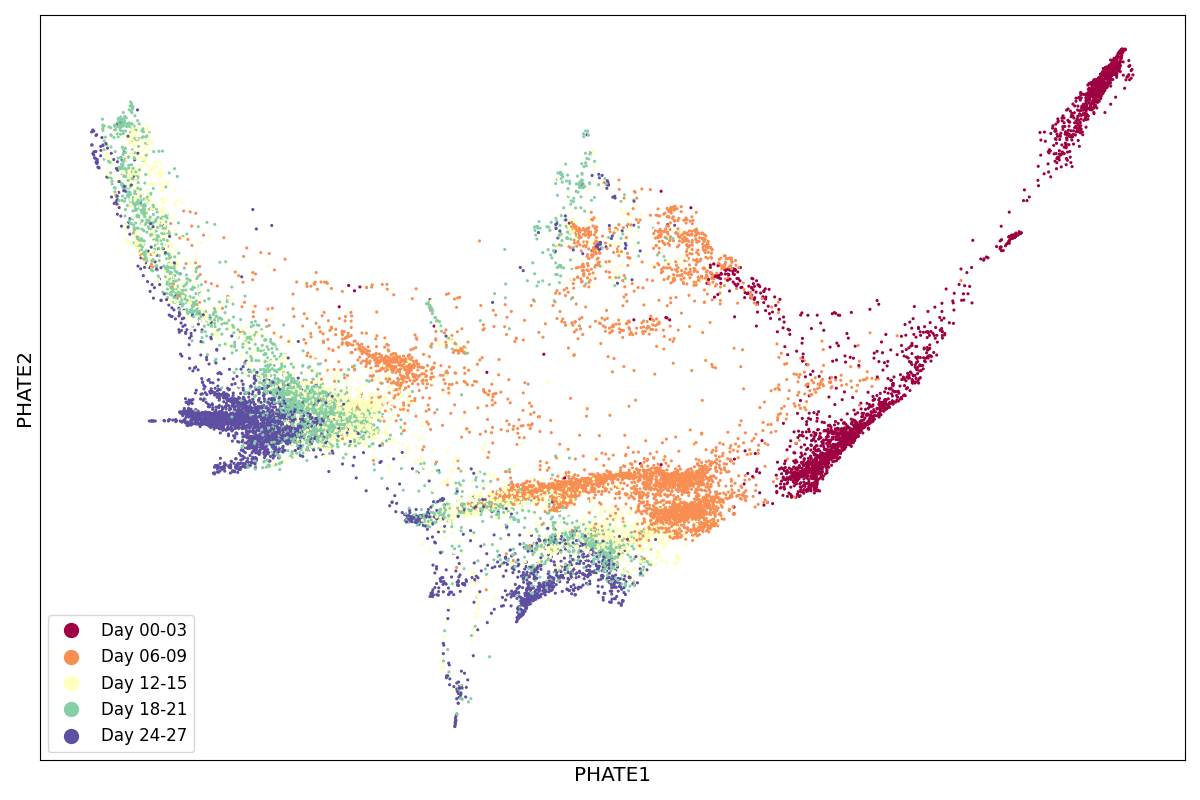

<Axes: xlabel='PHATE1', ylabel='PHATE2'>

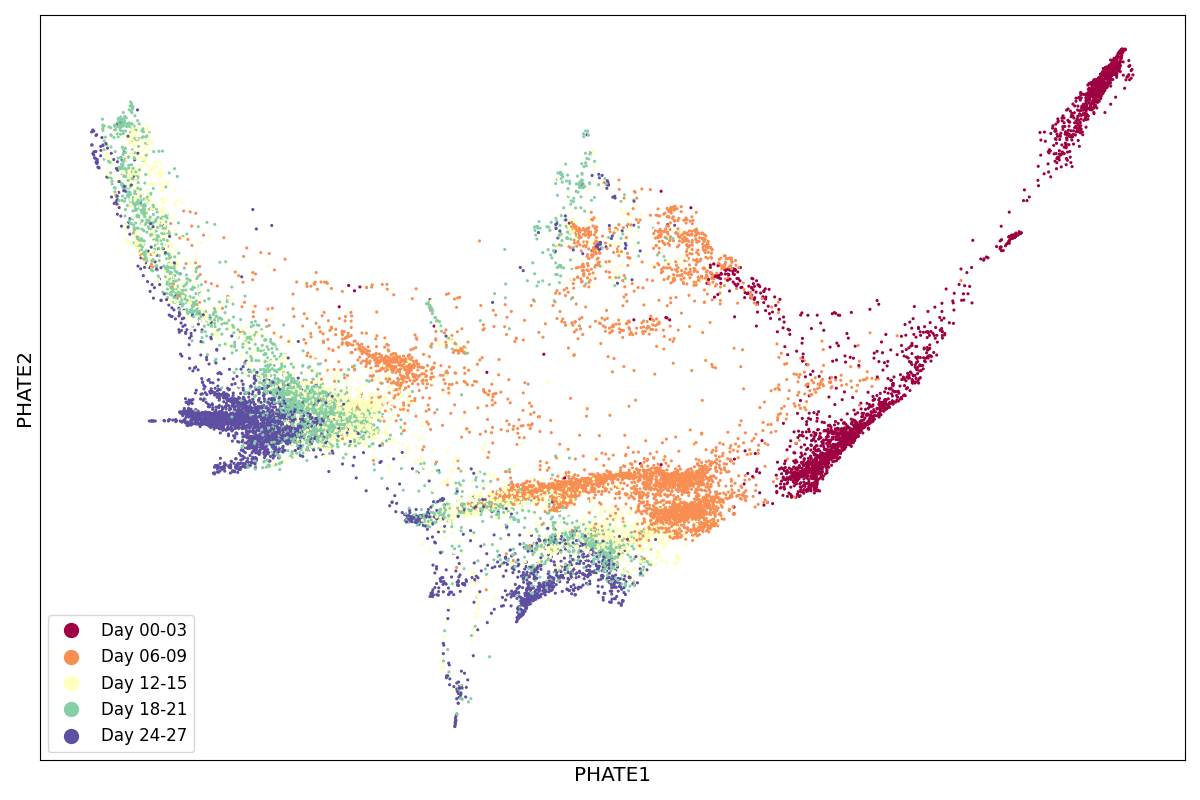

In [13]:
scprep.plot.scatter2d(Y_phate, c=sample_labels, figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

In [14]:
phate_operator = phate.PHATE(n_components = 3)

Y_phate3d = phate_operator.fit_transform(EBT_counts)

Calculating PHATE...
  Running PHATE on 16821 observations and 17845 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 20.24 seconds.
    Calculating KNN search...
    Calculated KNN search in 32.50 seconds.
    Calculating affinities...
    Calculated affinities in 1.43 seconds.
  Calculated graph and diffusion operator in 54.71 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.90 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.08 seconds.
  Calculated landmark operator in 3.82 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.99 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.22 seconds.
  Calculating metric MDS...


/home/ed667/.conda/envs/sheaf/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 18.15 seconds.
Calculated PHATE in 77.90 seconds.


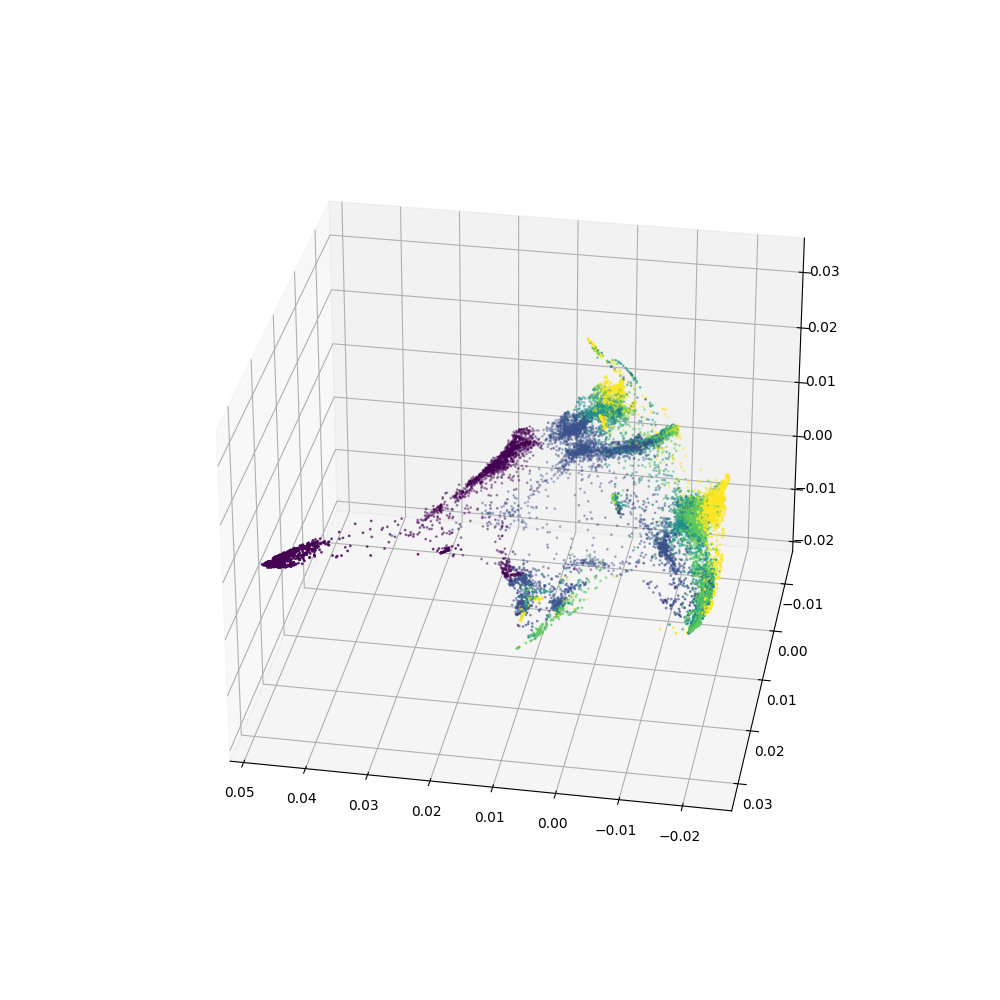

In [15]:
labels = sample_labels.map(dict(zip(sample_labels.unique(),np.arange(sample_labels.nunique())))).values
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(Y_phate3d[:,0], Y_phate3d[:,1], Y_phate3d[:,2], s=1, c=labels)
ax.view_init(elev=30, azim=100)

### Curvature computation

In [16]:
n_clusters = len(np.unique(phate_operator.graph.clusters))

sub_idx = []
for n_c in range(n_clusters):
    sub_idx.append(np.arange(len(Y_phate3d))[phate_operator.graph.clusters==n_c][0])

In [17]:
Y_phate_z = scipy.stats.zscore(Y_phate)[sub_idx]
n_points = len(Y_phate_z[np.abs(Y_phate_z[:,0])<3][np.abs(Y_phate_z[:,1])<3])
density = n_points / 9
print(density)

222.22222222222223


In [18]:
eb_3d = scipy.stats.zscore(Y_phate3d)[sub_idx]

In [19]:
num_eval = int(len(eb_3d))

curvature = []
for i in tqdm(range(num_eval)):
    a, b = compute_curvature(eb_3d, np.expand_dims(eb_3d[i], axis=0), epsilon_PCA = 0.5, tau_ratio = 3)
    curvature.append(b)

100%|██████████| 2000/2000 [09:29<00:00,  3.51it/s]


In [20]:
curv_dict = dict(zip(np.arange(len(sub_idx)),np.abs(curvature)))

In [33]:
Y_curv = np.log(np.vectorize(curv_dict.get)(phate_operator.graph.clusters))

In [34]:
scaled_Y_curv = np.abs(Y_curv) - np.nanmin(np.abs(Y_curv))
scaled_Y_curv = scaled_Y_curv / np.nanmax(scaled_Y_curv)

cc = scaled_Y_curv

In [35]:
cmap = plt.cm.get_cmap('Spectral')
spectral_reversed = cmap.reversed()

/tmp/ipykernel_1764927/2672575984.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Spectral')


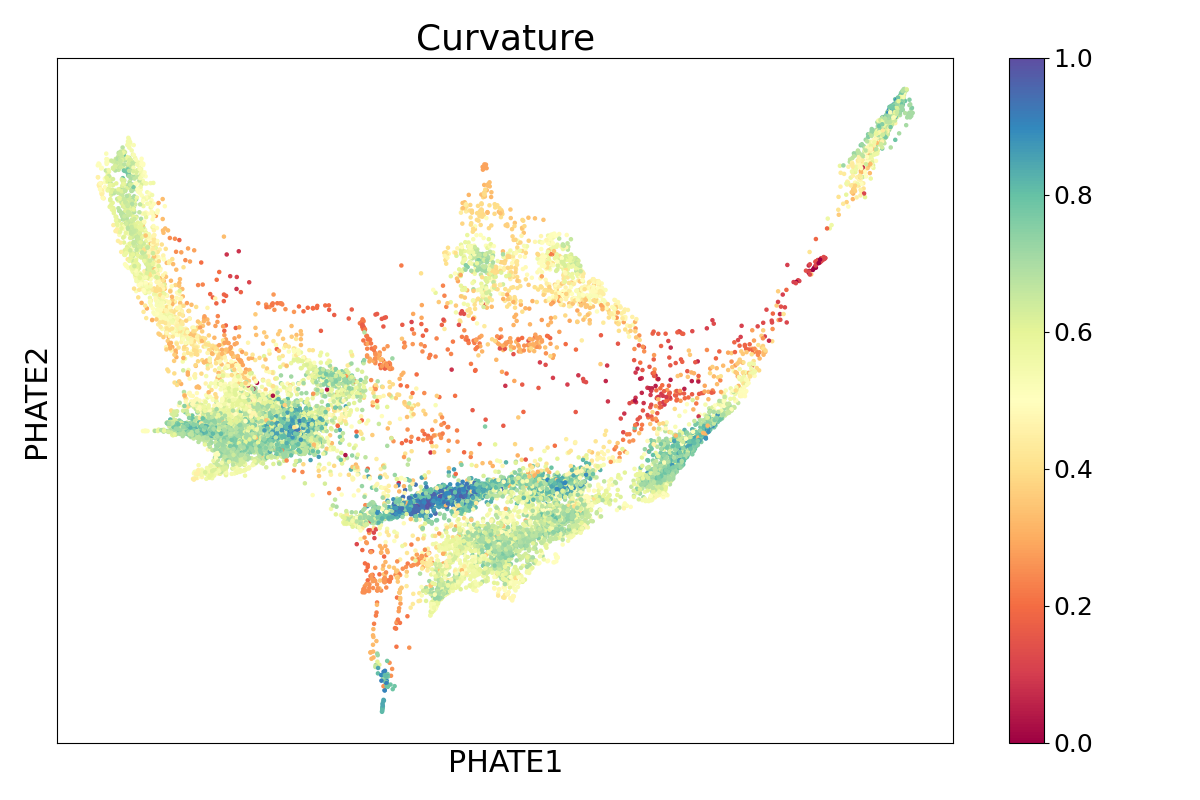

<Axes: title={'center': 'Curvature'}, xlabel='PHATE1', ylabel='PHATE2'>

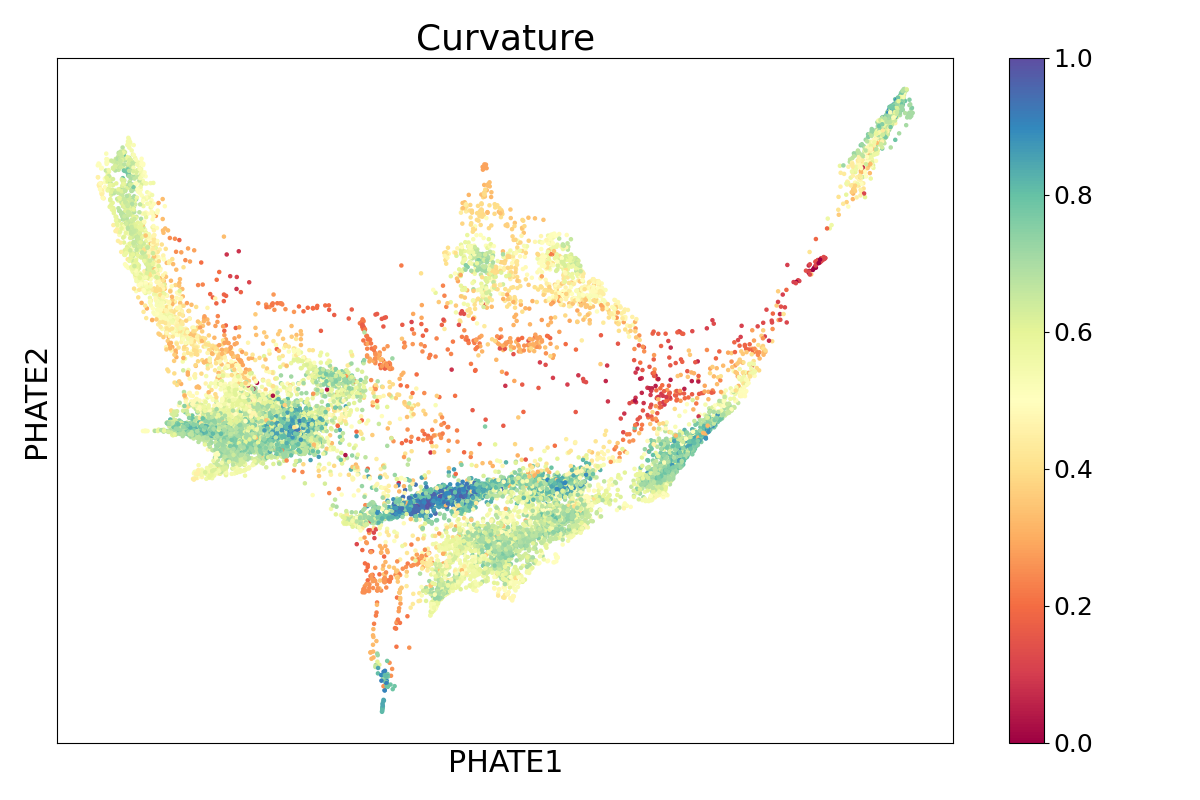

In [37]:
scprep.plot.scatter2d(Y_phate, c=cc, figsize=(12,8), cmap=cmap,
                      ticks=False, label_prefix="PHATE", title = "Curvature", fontsize = 15, s = 5)

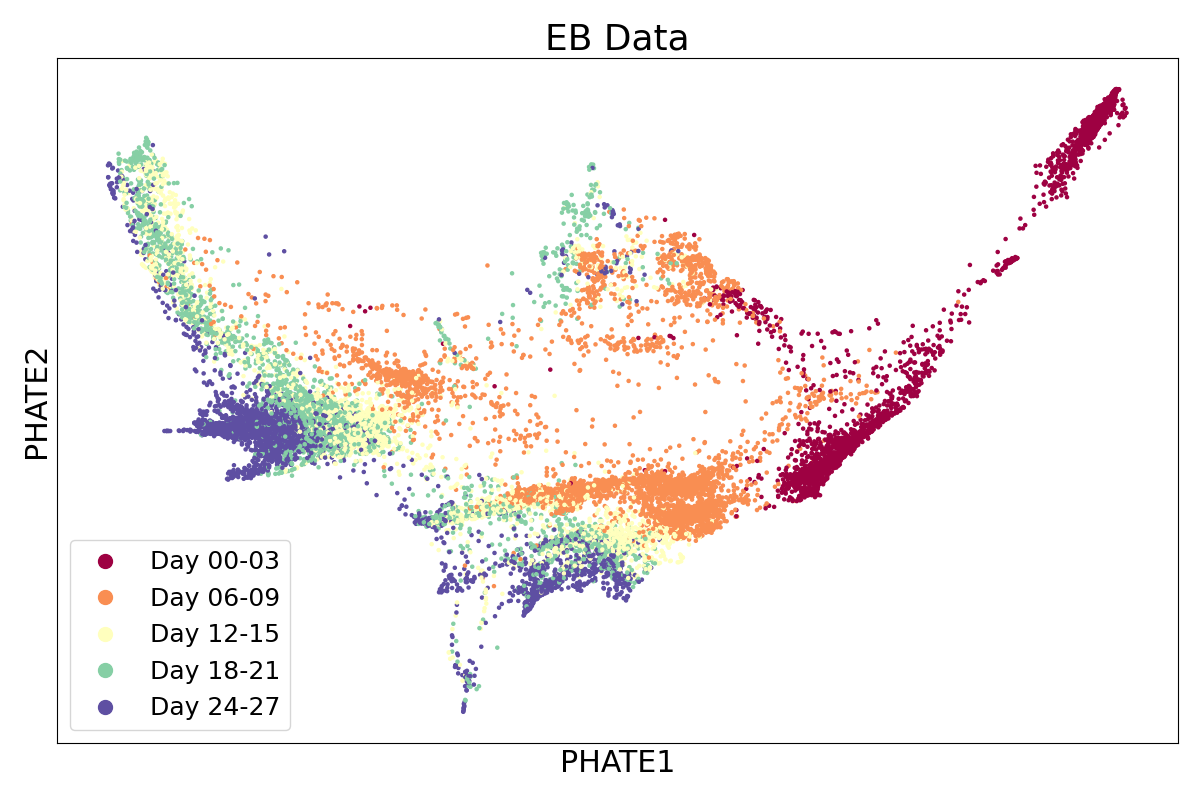

<Axes: title={'center': 'EB Data'}, xlabel='PHATE1', ylabel='PHATE2'>

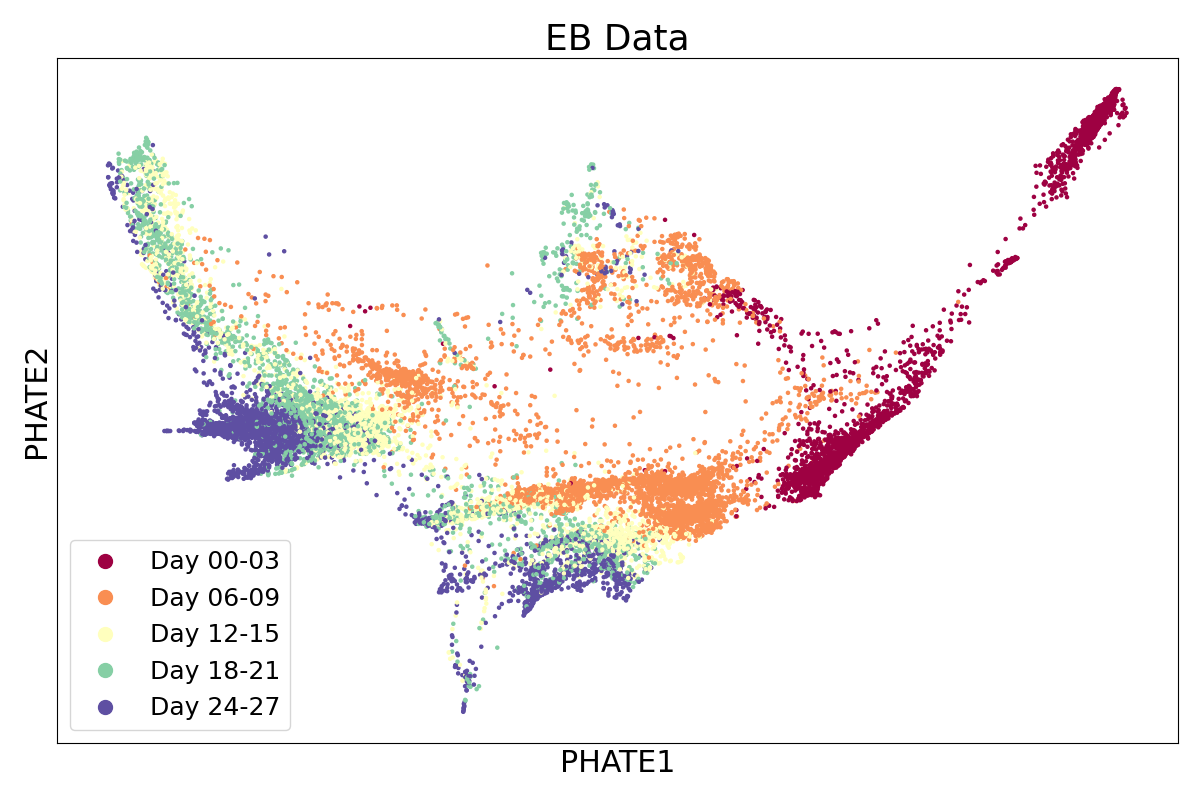

In [24]:
scprep.plot.scatter2d(Y_phate, c=sample_labels, figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE",fontsize=15, s = 5, title = "EB Data")

### Geodesic

In [56]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd

In [47]:
def sub_vectors_between(set_vectors, a, b):
    # this function selects a set of vectors whose entries are between a and b
    
    filtered_vector = [[x for x in v if a < x < b] for v in set_vectors ]
    return filtered_vector        

def list_vector_indices_upto(list_indices, list_of_nums):
    result_list = [[list_indices[i][j] for j in range(list_of_nums[i] + 1)] for i in range(len(list_indices))]
    return result_list

def list_vector_of_index(set_vectors, list_indices):
    
    list_result_vectors = [np.array([set_vectors[i] for i in list_indices[j]]) for j in range(len(list_indices))]
    return list_result_vectors 



def find_basis(point_cloud, x, epsilon_PCA = 0.1, dim = 2, tau_ratio = 1.5):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    epsilon_sqrt = np.sqrt(epsilon_PCA)
    tau = tau_ratio * epsilon_sqrt

    # Number of neighbors to find, we take 5% of the total population
    k = int(0.05 * point_cloud.shape[0])
    
    # Create a NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)

    # Find k nearest neighbors
    dist_i, indx_i = nbrs.kneighbors(x)
    # Find epsilon neighborhood
    dist_epsilon = sub_vectors_between(dist_i, 0, epsilon_sqrt)
    len_dist_epsilon = [len(v) for v in dist_epsilon]
    epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_epsilon))[0]
    # Find tau neighborhood
    dist_tau = sub_vectors_between(dist_i, 0, tau)
    len_dist_tau = [len(v) for v in dist_tau]
    tau_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_tau))[0]
    num = len(tau_neighborhood)
    
    distances, indices = nbrs.kneighbors(tau_neighborhood)
    
    distances_epsilon = sub_vectors_between(distances, 0, epsilon_sqrt) # this is the list of distances in the epsilon
    list_len_dist_epsilon = [len(v) for v in distances_epsilon] #this gives the list of lengths in the distance_epsilon 
    
    tau_epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indices, list_len_dist_epsilon))
    list_X_i = [tau_epsilon_neighborhood[i][1:] - tau_neighborhood[i] for i in range(num)]
    
    
    #list_D_i = [np.diag(np.sqrt(np.exp(- np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for i in range(num)]
    list_D_i = [np.diag(np.sqrt(np.exp( - 5 * np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for 
                i in range(num)]
    list_B_i = [list_X_i[j].T @ list_D_i[j] for j in range(num)]
    O = []
    for q in range(num):
        U, S, VT = np.linalg.svd(list_B_i[q], full_matrices = False)
        O_i = U[:, :dim]
        O.append(O_i)
        
    return epsilon_neighborhood, tau_neighborhood, tau_epsilon_neighborhood, O



In [46]:
import numpy as np


## the following is our functions on data cloud   

def log_map_manifold(point_cloud, p, q, stalk_dim = 2, k = 400, epsilon_PCA = 0.1):
    #we first find the basis at point p
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(point_cloud)
    dist_p, p_nbrs_index = nbrs.kneighbors(np.expand_dims(p, axis = 0))
    x_N_p = list_vector_of_index(point_cloud, p_nbrs_index)[0][1:]
    X_i_p = x_N_p - p
    D_i_p = np.diag(np.sqrt(np.exp( - 5 * np.array(dist_p[0][1:]) ** 2 / epsilon_PCA)))
    U_p, S_p, VT_p = np.linalg.svd(X_i_p.T @ D_i_p, full_matrices = False)
    O_p = U_p[:, :stalk_dim]
    
    #then we project the vector q - p to the basis at O_p
    v = q - p
    v_proj = np.dot(v, O_p.T[0]) * O_p.T[0] + np.dot(v, O_p.T[1]) * O_p.T[1]
    return v_proj   
    

def parallel_transport_manifold(point_cloud, v, p, q, stalk_dim = 2, k = 400, epsilon_PCA = 0.1):
    
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(point_cloud) 
    #compute basis at p
    dist_p, p_nbrs_index = nbrs.kneighbors(np.expand_dims(p, axis = 0))
    x_N_p = list_vector_of_index(point_cloud, p_nbrs_index)[0][1:]
    X_i_p = x_N_p - p
    D_i_p = np.diag(np.sqrt(np.exp( - 5 * np.array(dist_p[0][1:]) ** 2 / epsilon_PCA)))
    U_p, S_p, VT_p = np.linalg.svd(X_i_p.T @ D_i_p, full_matrices = False)
    O_p = U_p[:, :stalk_dim]
    
    #compute basis at q
    dist_q, q_nbrs_index = nbrs.kneighbors(np.expand_dims(q, axis = 0))
    x_N_q = list_vector_of_index(point_cloud, q_nbrs_index)[0][1:]
    X_i_q = x_N_q - q
    D_i_q = np.diag(np.sqrt(np.exp( - 5 * np.array(dist_q[0][1:]) ** 2 / epsilon_PCA)))
    U_q, S_q, VT_q = np.linalg.svd(X_i_q.T @ D_i_q, full_matrices = False)
    O_q = U_q[:, :stalk_dim]
    
    #compute parallel transport
    U, S, VT = np.linalg.svd(O_p.T @ O_q, full_matrices = False)
    O_pq = U @ VT #this is a matrix of 2 x 2
    
    #transport the vector v to at point q
    v_0 = np.array([np.dot(v, O_p.T[0]), np.dot(v, O_p.T[1])])
    v_q = O_pq @ v_0
    v_q = v_q[0] * O_q.T[0] + v_q[1] * O_q.T[1]  #change it to the vector form of coord (x, y, z)
    
    return v_q

def geodesic_distance_manifold(p, q):
    norm = np.linalg.norm(q - p)
    return norm

def exp_map_manifold(point_cloud, p, v, k = 100):
    #p: (n-array) the initial point p in the point cloud   v: (n-array) the dirctional vector 
    #k: number of neighbors used for finding best transported point
    
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(point_cloud)  
    dist, p_new_index = nbrs.kneighbors(np.expand_dims(p + v, axis = 0))
    q = point_cloud[p_new_index[0][0]]
    
    return q

#compute gradients
def grad(point_cloud, x0, v, x1, t, N):
    # x0: initial point. x1: final point  t = np.linspace(0, 1, num = N)
    grad_v = 0
    for i in range(N):
        mapped_value = exp_map_manifold(point_cloud, x0, v * t[i])
        error_vec = log_map_manifold(point_cloud, mapped_value, x1)
        error_vec_transported = parallel_transport_manifold(point_cloud, error_vec, mapped_value, x0) 
        grad_v += error_vec_transported * t[i]
        
    return -1*grad_v/N

  
def compute_cost(x, y):
    
    err = geodesic_distance_manifold(x,y)
    return err

In [44]:
def run_exp(point_cloud, x0, x1, num_epochs = 100, num_interpolation = 20, dim = 3, lr = 0.1):
    # x0: starting point, array([a, b, c])
    # x1: final point, array([a, b, c])
    # num_interpolation: the number of points to interpolate
    # dim: the dimension of the ambient space. Example: sphere is 3
    # lr: learning rate
    t = np.linspace(0, 1, num = num_interpolation)
   
    #initializing a shooting direction, here we use (x1 - x0) + gaussian noise
    cov = np.identity(dim)
    x1_noise = np.random.multivariate_normal(x1, cov, size=num_epochs)
    v_initials = x1_noise - x0
    
    #first loss
    cost_epoch =[]
    interpolation = []
    for k in tqdm(range(num_epochs)):
        v = v_initials[k]
        v_all = []
        iterations = 20
        costs = np.array([])
        for i in range(iterations):
            grad_v = grad(point_cloud, x0, v, x1, t, num_interpolation)
            v = v - lr * grad_v
    
            v_all.append(v)
            v_array = np.dot(t.reshape(-1,1),v.reshape(1,-1))
            model_output = np.array([exp_map_manifold(point_cloud, x0, v_array[i]) for i in range(num_interpolation)])
            costs = np.append(costs,compute_cost(x1,model_output[-1]))
        v_all = np.vstack(v_all)
        lowest = np.where(costs == min(costs))[0][0]
        cost_epoch.append(min(costs))
        V = v_all[lowest]
        V_array = np.dot(t.reshape(-1,1),V.reshape(1,-1))
        model_output = np.array([exp_map_manifold(point_cloud, x0, V_array[i]) for i in range(num_interpolation)])
        interpolation.append(model_output)
    interpolation = np.stack(interpolation, axis =0)
    best_epoch = np.where(cost_epoch == min(cost_epoch))[0][0]
    best_fit = interpolation[best_epoch]
    loss = sorted(cost_epoch, reverse=True)
    return best_fit, loss

In [139]:
point_cloud = eb_3d.copy()
x0 = point_cloud[17]
x1 = point_cloud[200]

In [138]:
np.where((point_cloud[:,2] < 3) * (point_cloud[:,2]>2))

(array([  17,   42,   72,  170,  237,  292,  294,  295,  483,  563,  607,
         627,  635,  759,  834,  880,  914,  961, 1008, 1046, 1063, 1249,
        1294, 1319, 1453, 1548, 1552, 1575, 1657, 1691, 1771, 1865, 1893,
        1897]),)

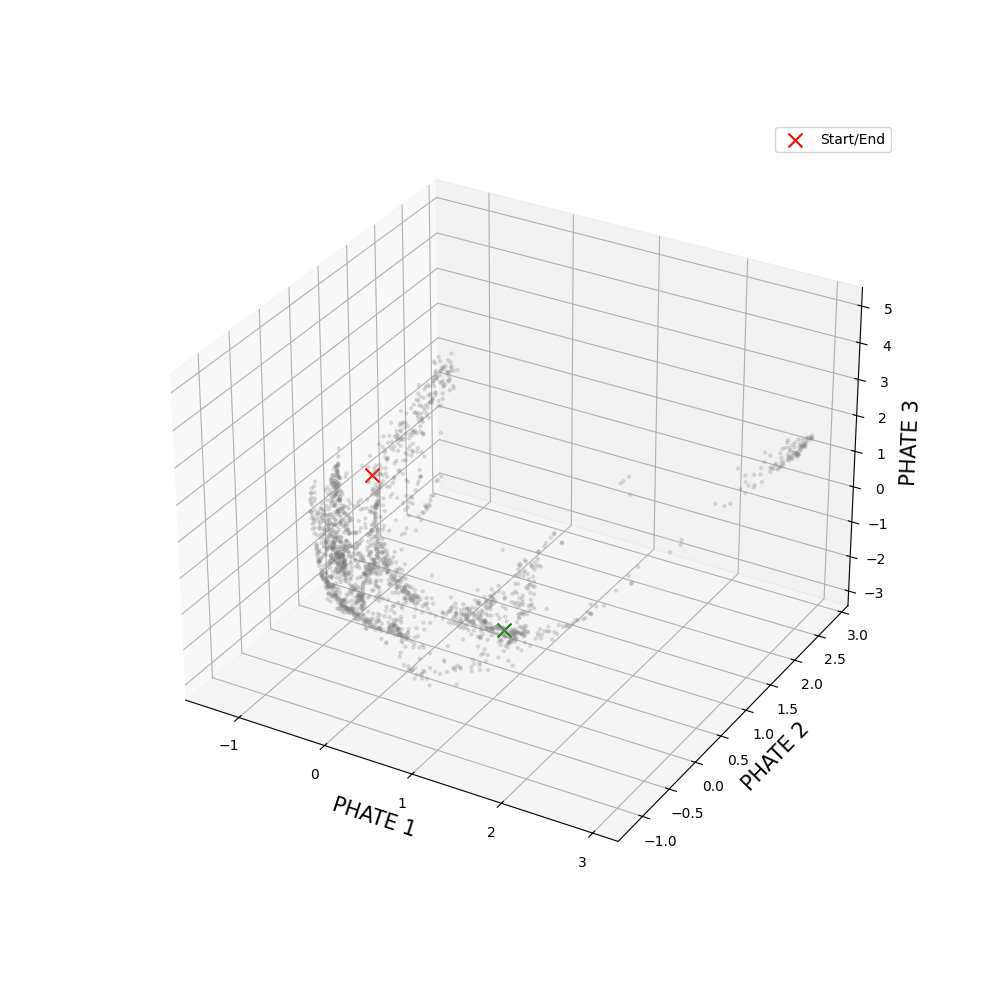

In [140]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], s=5, color = "grey",alpha = 0.2)
ax.scatter(x0[0][None], x0[1][None], x0[2][None], s=100, color = "red", marker = "x", label = "Start/End")
ax.scatter(x1[0][None], x1[1][None], x1[2][None], s=100, color = "green", marker = "x")
#ax.plot(smooth_traj[:,0],smooth_traj[:,1])
ax.set_xlabel("PHATE 1", fontsize = 15)
ax.set_ylabel("PHATE 2", fontsize = 15)
ax.set_zlabel("PHATE 3", fontsize = 15)
#ax.tick_params(left=False,
#            bottom=False,
#            labelleft=False,
#            labelbottom=False)
ax.legend()

In [141]:
interpolation_points, loss = run_exp(point_cloud, x0, x1, num_epochs = 50)

100%|██████████| 50/50 [01:50<00:00,  2.20s/it]


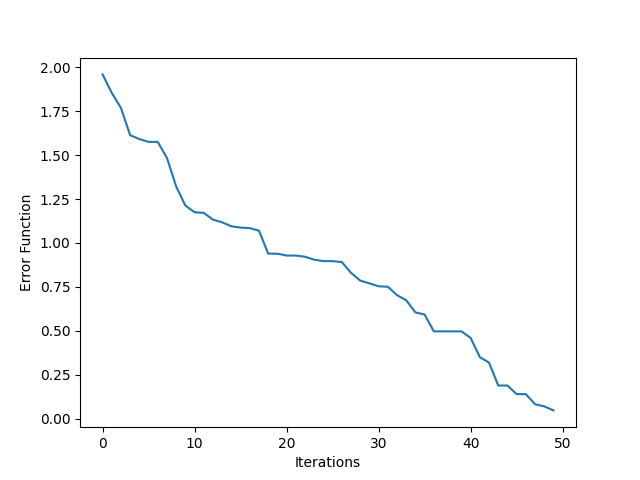

In [142]:
plt.figure()
plt.plot(loss)
plt.ylabel("Error Function")
plt.xlabel("Iterations")
plt.show()

In [145]:
from scipy.signal import savgol_filter
smooth_traj = savgol_filter(interpolation_points, 20, 3,axis = 0)

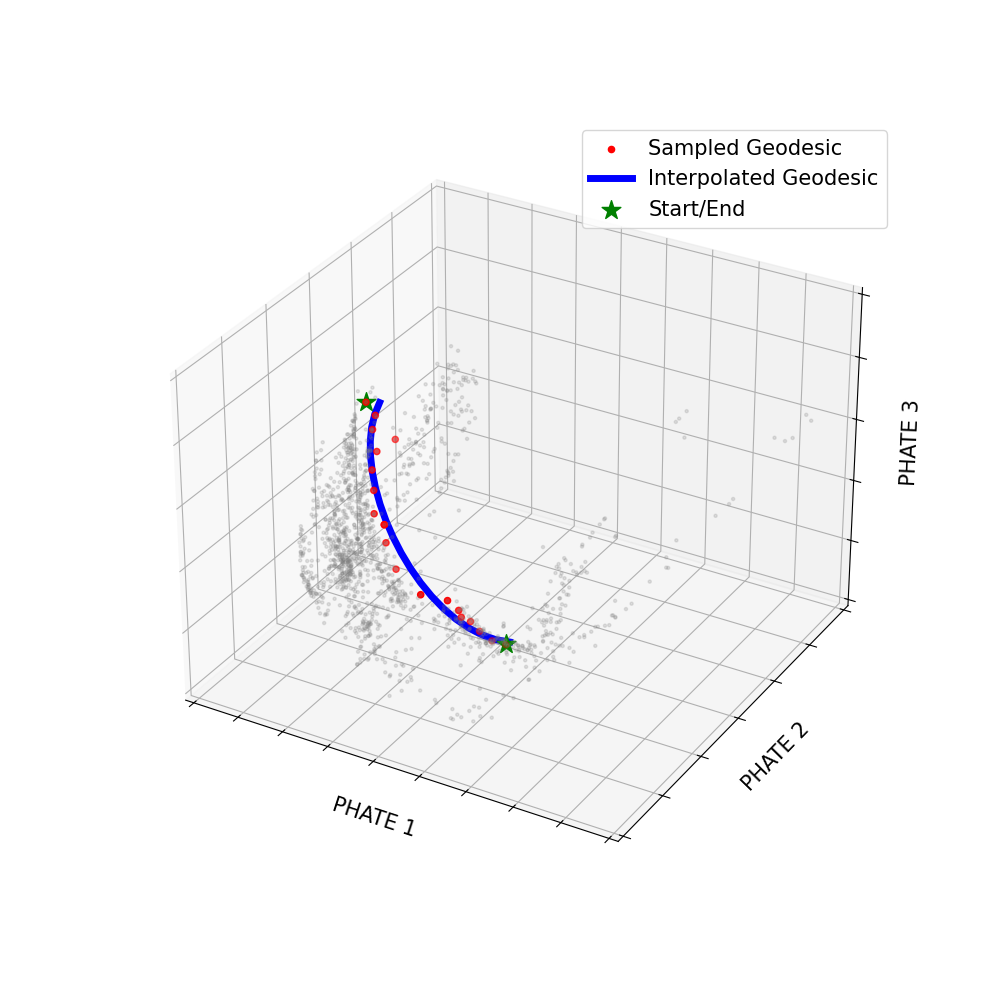

In [161]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
idx_mask = (point_cloud[:,0] >-1.5) * (point_cloud[:,0] <4) * (point_cloud[:,1] >-1) * (point_cloud[:,1] <2) * (point_cloud[:,2] >-2) * (point_cloud[:,2] <3)
#idx_mask = np.arange(len(point_cloud))
ax.scatter(interpolation_points[:,0], interpolation_points[:,1], interpolation_points[:,2], s=20, color = "red", label = "Sampled Geodesic")
ax.plot(smooth_traj[:,0],smooth_traj[:,1],smooth_traj[:,2], color = "blue", linewidth = 5, label = "Interpolated Geodesic")
ax.scatter(point_cloud[idx_mask,0], point_cloud[idx_mask,1], point_cloud[idx_mask,2], s=5, color = "grey",alpha = 0.2)
ax.scatter(x0[0][None], x0[1][None], x0[2][None], s=200, color = "green", marker = "*", label = "Start/End")
ax.scatter(x1[0][None], x1[1][None], x1[2][None], s=200, color = "green", marker = "*")
#ax.plot(smooth_traj[:,0],smooth_traj[:,1])
ax.set_xlabel("PHATE 1", fontsize = 15)
ax.set_ylabel("PHATE 2", fontsize = 15)
ax.set_zlabel("PHATE 3", fontsize = 15)
ax.tick_params(left=False,
            bottom=False,
            labelleft=False,
            labelbottom=False)
ax.set_xlim(-1.5,3)
ax.set_ylim(-1,2)
ax.set_zlim(-2,3)
ax.legend(fontsize = 15)

## PBMC

In [3]:
with open('../data/pbmc.pickle','rb') as f:
        X = pickle.load(f).values.squeeze()
pca = PCA(n_components=10)
pca.fit(X)
pbmc_data = X @ pca.components_.T

In [24]:
phate_operator = phate.PHATE(random_state=42, verbose=True, n_components=3, knn=5)    
pbmc_phate = phate_operator.fit_transform(X, t_max = 500)
pbmc_phate = scipy.stats.zscore(pbmc_phate) 

Calculating PHATE...
  Running PHATE on 2638 observations and 1838 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.99 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.81 seconds.
    Calculating affinities...
    Calculated affinities in 0.28 seconds.
  Calculated graph and diffusion operator in 5.08 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.34 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.00 seconds.
  Calculated landmark operator in 3.94 seconds.
  Calculating optimal t...
    Automatically selected t = 41
  Calculated optimal t in 0.72 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.18 seconds.
  Calculating metric MDS...


/home/ed667/.conda/envs/sheaf/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 64.63 seconds.
Calculated PHATE in 74.56 seconds.


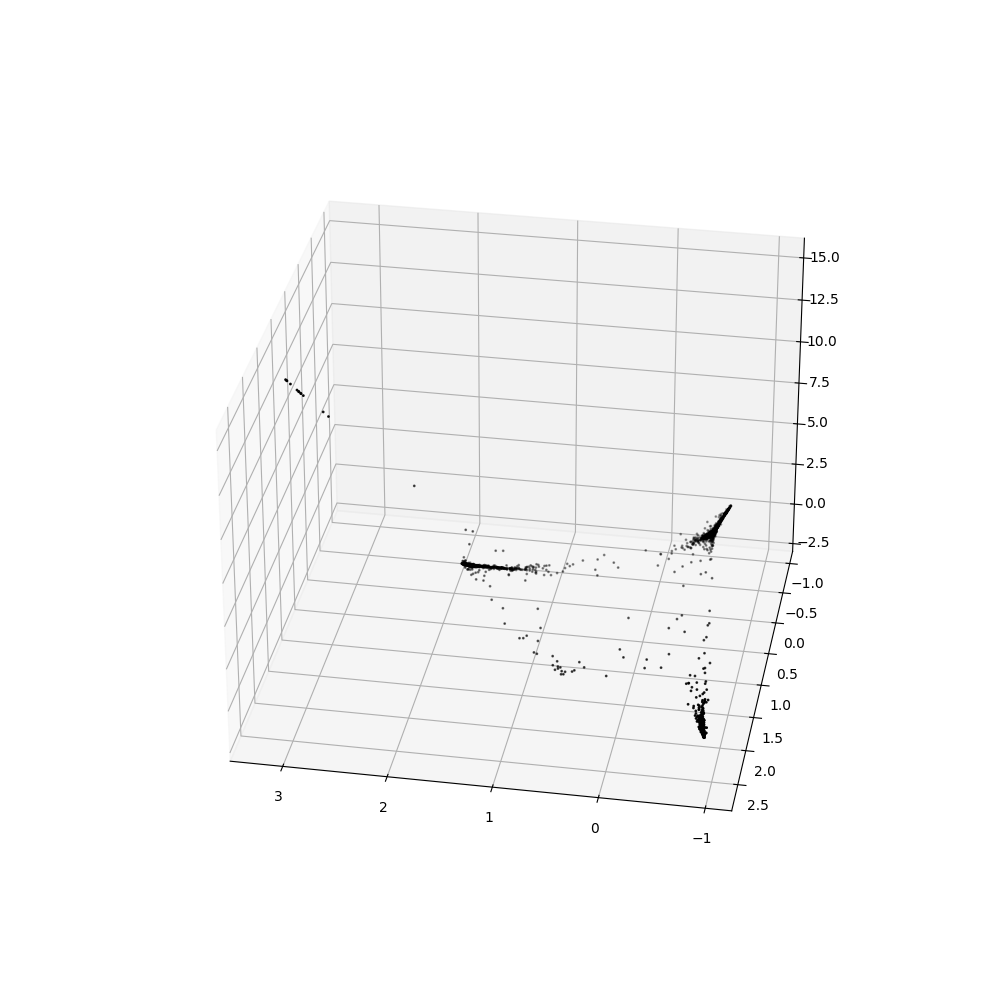

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(pbmc_phate[:,0], pbmc_phate[:,1], pbmc_phate[:,2], s=1, c='k')
ax.view_init(elev=30, azim=100)

In [27]:
len(pbmc_phate)

2638

In [31]:
num_eval = int(len(pbmc_phate)/10)

curvature = []
for i in tqdm(range(num_eval)):
    a, b = compute_curvature(pbmc_phate, np.expand_dims(pbmc_phate[i], axis=0), epsilon_PCA = 0.5, tau_ratio = 2)
    curvature.append(b)

  0%|          | 1/263 [00:00<02:06,  2.07it/s]/tmp/ipykernel_3219142/1545380931.py:88: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosin)
 24%|██▎       | 62/263 [00:30<01:37,  2.05it/s]/tmp/ipykernel_3219142/1545380931.py:88: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosin)
 28%|██▊       | 73/263 [00:35<01:31,  2.07it/s]/tmp/ipykernel_3219142/1545380931.py:88: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosin)
 30%|███       | 80/263 [00:38<01:28,  2.06it/s]/tmp/ipykernel_3219142/1545380931.py:88: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosin)
 59%|█████▊    | 154/263 [01:14<00:52,  2.07it/s]/tmp/ipykernel_3219142/1545380931.py:88: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosin)
 60%|█████▉    | 157/263 [01:15<00:51,  2.07it/s]/tmp/ipykernel_3219142/1545380931.py:88: RuntimeWarning: invalid value encountered in arccos
  angle = np.arcco

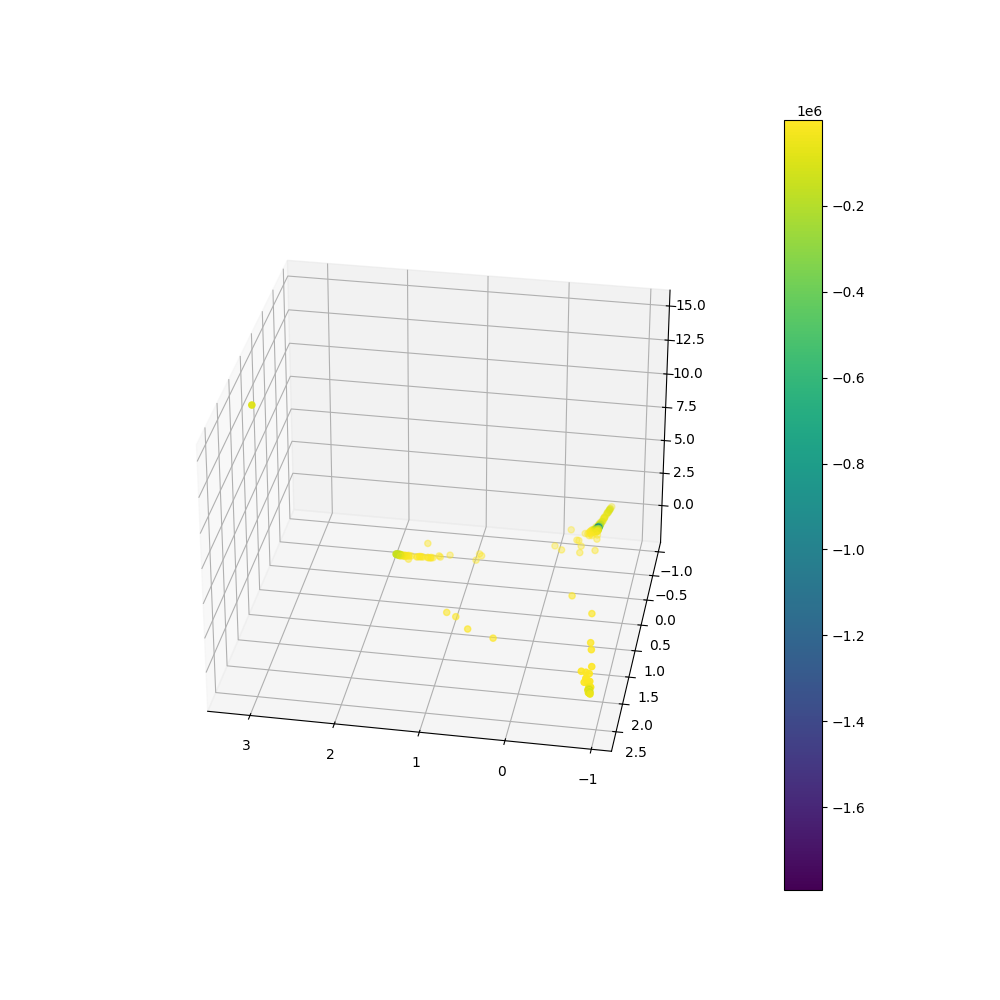

In [32]:
v = np.array(curvature)
# Visualize the point cloud
cc = - v

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

sc = ax.scatter(pbmc_phate[:num_eval,0], pbmc_phate[:num_eval,1], pbmc_phate[:num_eval,2], s=20, c=cc)
plt.colorbar(sc)
ax.view_init(elev=30, azim=100)

## IPSC

In [10]:
X = sio.loadmat('../data/ipscData.mat')['data']
X = X[:5000]
phate_operator = phate.PHATE(random_state=42, verbose=True, n_components=2, knn=5)    
ipsc_phate = phate_operator.fit_transform(X, t_max = 500)

Calculating PHATE...
  Running PHATE on 5000 observations and 33 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.84 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.86 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.79 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.00 seconds.
  Calculated landmark operator in 4.44 seconds.
  Calculating optimal t...
    Automatically selected t = 51
  Calculated optimal t in 0.94 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.29 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.60 seconds.
Calculated PHATE in 10.14 seconds.


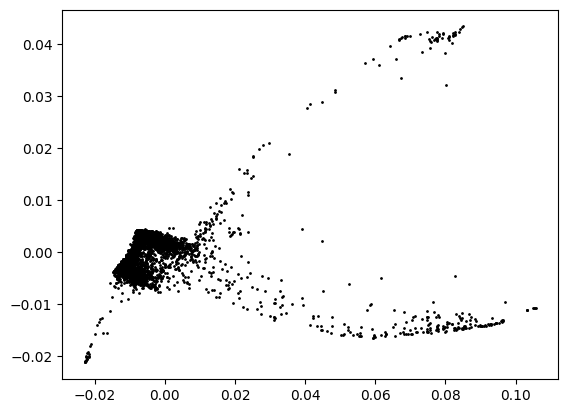

In [11]:
plt.scatter(ipsc_phate[:,0], ipsc_phate[:,1], s=1, c='k')

In [2]:
def generate_torus_point_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)

    return np.column_stack((x, y, z))

# Create torus parameters
R = 1 # Major radius
r = 0.375  # Minor radius
num_samples = 5000